# NEOPRENE notebooks

***

This notebook is part of a notebook collection available at the [NEOPRENE Project Site](https://github.com/IHCantabria/NEOPRENE) for illustration, reproducibility and reusability purposes. This notebook is licensed under the [Creative Commons Attribution 4.0 International License](http://creativecommons.org/licenses/by/4.0).

![Creative Commons License >](https://i.creativecommons.org/l/by/4.0/88x31.png)

# Calibrating and synthetic simulations of Rainfall with the STNSRPM.


In this script we calibrate the STNSRPM (Spatio Temporal Neyman Scott Rectangular Pulse Model) using several rainfall series from Tenerife Island with a semi-arid climate (BSh-BSk). The calibration parameters are used to simulate several decades of synthetic rainfall data which can be very useful for rainfall extreme analysis or disaggregation purposes, among other things.

The script also contains:

1. a validation section where the observed series are compared with the simulated ones in terms of their statistics and exceedance probabilities. 

2. a disaggregation function to disaggreate daily to hourly rainfall data.

### Load packages

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from scipy.interpolate import interp1d
import tqdm

In [3]:
import math as mt
from datetime import date
from datetime import timedelta
from scipy import stats

In [4]:
from NEOPRENE.STNSRP.HiperParams import Calibration as Calhps, Simulation as Simhps
from NEOPRENE.STNSRP.Statistics import Statistics
from NEOPRENE.STNSRP.utils import compare_statistics, datetime2matlabdnJavi 
from NEOPRENE.STNSRP.Calibration import Calibration
from NEOPRENE.STNSRP.MathematicalPropertiesSTNSRP import STNSRP_fi_min
from NEOPRENE.NSRP.Simulation import Simulation as Simulation_NSRP
from NEOPRENE.STNSRP.Simulation import Simulation

In [5]:
import warnings
warnings.filterwarnings('ignore')

In [6]:
import sys
sys.path.insert(1, '../NEOPRENE/')

In [7]:
import time
start_time = time.time()

### Loading daily rainfall for Tenerife Island (now for Sierra Nevada)

__Cuidado que las series tienen que ser coetáneas en el tiempo__

In [8]:
path_1 = './auxiliary-materials/SN/'

In [9]:
## Loading rainfall series
Series_SN = pd.read_csv(path_1 + 'DailySN.csv', index_col=0, parse_dates=True)
Series_SN[Series_SN.values<0]=np.nan
Input_Series=Series_SN.copy()
del Series_SN

In [10]:
## Loading attributes for the series
Attributes_SN = pd.read_csv(path_1 + 'AtributosSN.csv', index_col=0)
Input_Attr=pd.DataFrame()
Input_Attr['ID']=[str(i) for i in Attributes_SN.field_1.values]
Input_Attr['X']=Attributes_SN.Long.values
Input_Attr['Y']=Attributes_SN.Lat.values
Input_Attr['Elevation']=Attributes_SN.field_4.values
del Attributes_SN

In [11]:
Input_Attr = Input_Attr.iloc[0:5]

In [12]:
## Shorting ID series to match with Input_Attr
Input_Series = Input_Series[Input_Attr.ID]

<AxesSubplot:>

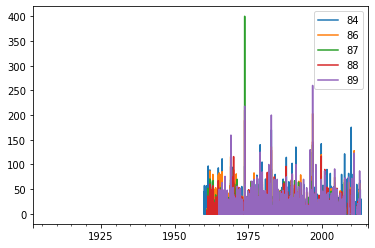

In [13]:
Input_Series.plot()

### Plotting rainfall series, seasonality and gauge position

Text(0, 0.5, 'mm/month')

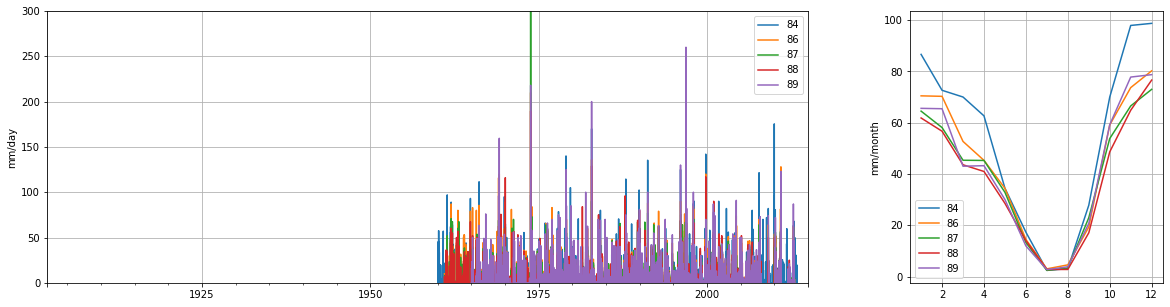

In [14]:
f, (ax0, ax1) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [3, 1]}, figsize=(20, 5))

t1=str(Input_Series.index.year[0]); t2=str(Input_Series.index.year[-1])
Input_Series.plot(xlim=(t1, t2),  ylim=(0, 300), ax = ax0)
ax0.grid(True)
ax0.set_ylabel('mm/day')

grouped_m = Input_Series.groupby(lambda x: x.month)
Month_sum=grouped_m.sum()*24/(len(Input_Series>=0)/30)
Month_sum.plot(ax = ax1)
ax1.grid(True)
ax1.set_ylabel('mm/month')

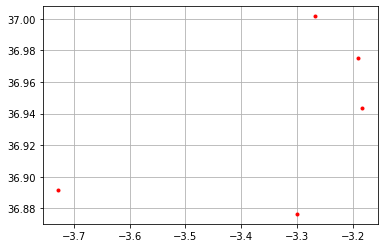

In [15]:
plt.plot(Input_Attr.X, Input_Attr.Y, '.r')
plt.grid()

### Calibration

Compleate...

In [16]:
# Reading hiperparamteres for the calibration
hiper_params_cal = Calhps('./Input_Cal_SN.yml')

In [ ]:
# Input statistics calculated from several Rainfall series
statistics_model_1 = Statistics(hiper_params_cal, time_series = Input_Series, attributes = Input_Attr)

# Input statistics from file 
#statistics_model_2 = Statistics(hiper_params_cal, file = 'auxiliary-materials/statististics_Bilbao.csv')

In [ ]:
CAL              = Calibration(hiper_params_cal) 
CAL1             = CAL(statistics_model_1, Input_Series, verbose=True)
CAL1.save_files('./CAL4/')#save python objects

In [ ]:
# Reading hiperparamteres for the simulation
hiper_params_sim = Simhps('./Input_Sim_SN.yml')

In [ ]:
SIM              = Simulation(hiper_params_sim) 
# Input parameters from the model

#SIM1             = SIM(params_cal = CAL1, Input_Series = Input_Series, Input_Attr = Input_Attr)
SIM1             = SIM(params_cal =['./CAL4/Calibrated_parameters.csv',
                                    './CAL4/xi_months.csv'], 
                       Input_Series = Input_Series, Input_Attr = Input_Attr)

In [ ]:
SIM1.save_files('./SIM4/')

In [ ]:
SIM1.statististics_Simulated

In [ ]:
print("--- %s seconds ---" % (time.time() - start_time))